# CNN for Shape Dimensions

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms 
from torch.utils.data import DataLoader

from data_load import ShapeDimensionDataset
from regression import Net1, train_regression

## Transformations

In [2]:
## Define Transforms

full_transform = transforms.Compose([
    # these operate on PIL image
    transforms.Resize((100, 100), interpolation=0),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # the fill thing needs to be 255 (white); we're still in uint8 mode
    transforms.RandomRotation((0,90), expand=True, fill=255),
    # Normalise wants a tensor as input, so ToTensor has to run first
    transforms.ToTensor(), 
    transforms.Normalize(0, 1), 
])

flip_transform = transforms.Compose([
    # these operate on PIL image
    transforms.Resize((100, 100), interpolation=0),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # Normalise wants a tensor as input, so ToTensor has to run first
    transforms.ToTensor(), 
    transforms.Normalize(0, 1), 
])

no_transform = transforms.Compose([
    # Normalise wants a tensor as input, so ToTensor has to run first
    transforms.Resize((100, 100), interpolation=0),
    transforms.ToTensor(), 
    transforms.Normalize(0, 1), 
])

## Datasets and Dataloaders

omit test for the time being ...

In [3]:
parameters = ["h", "tw", "ba", "ra"]
target_cols = ["h_scaled", "tw_scaled", "ba_scaled", "ra_scaled"]

datasets = {
    'train': ShapeDimensionDataset("dataset/L2_train.csv", 
                                   "dataset/train/L2/",
                                   transform=flip_transform, 
                                   target_cols=target_cols),
    'val': ShapeDimensionDataset("dataset/L2_val.csv", 
                                 "dataset/val/L2/",
                                 transform=flip_transform, 
                                 target_cols=target_cols),    
}

In [4]:
BATCH_SIZE = 32

dataloaders = {'train': DataLoader(datasets['train'], 
                                   batch_size=BATCH_SIZE,
                                   shuffle=True, 
                                   num_workers=6),
               'val': DataLoader(datasets['val'], 
                                 batch_size=BATCH_SIZE,
                                 shuffle=False, 
                                 num_workers=6),                                       
    }


## Show something

Convert PIL grayscale image (type=L) to np array (axes are still flipped):

`img = np.frombuffer(img_.tobytes(), dtype=np.uint8).reshape(224,224)`

Convert torch.Tensor to np array:



pixel value range: 0.0 1.0
shape: (100, 100)
dtype: float32
[[0.85637428]
 [0.11926557]
 [0.32567999]
 [0.2473557 ]]


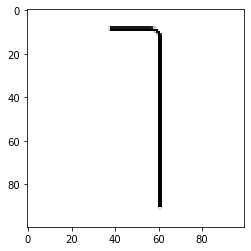

In [5]:
ds = datasets['train']

img_, y = ds[67]  
# TODO: how to rotate ???
img = img_[0].numpy() # shape(1,224,224) -> shape(224,224)
img = img.squeeze()
print("pixel value range:", np.min(img), np.max(img))
# TODO: these are grayscale (B/W) pictures. One depth dimension is enough.
print("shape:", img.shape)
print("dtype:", img.dtype)
print(y)
plt.imshow(img, cmap='gray');



In [6]:
def plot_history(history, log=False):
    """history plot, return image"""
    fig, ax = plt.subplots()
    ax.plot(history['train'], "o-", label="train")
    ax.plot(history['val'], "o-", label="val")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    if log:
        ax.semilogy()
    ax.grid()
    ax.legend()

## Settings

In [7]:
lr = 0.0003

model = Net1(4, image_size=100, param_names=["h", "tw", "ba", "ra"], description="L2")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
print(model)
 

Net1(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1936, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=4, bias=True)
)


Epoch 1/400: train Loss: 0.041981 val Loss: 0.025136 

Epoch 2/400: train Loss: 0.017135 val Loss: 0.012154 

Epoch 3/400: train Loss: 0.011240 val Loss: 0.009635 

Epoch 4/400: train Loss: 0.009119 val Loss: 0.007749 

Epoch 5/400: train Loss: 0.006877 val Loss: 0.006014 

Epoch 6/400: train Loss: 0.005217 val Loss: 0.004682 

Epoch 7/400: train Loss: 0.004085 val Loss: 0.004151 

Epoch 8/400: train Loss: 0.003558 val Loss: 0.003495 

Epoch 9/400: train Loss: 0.003098 val Loss: 0.003006 

Epoch 10/400: train Loss: 0.003087 val Loss: 0.002817 

Epoch 11/400: train Loss: 0.002526 val Loss: 0.002566 

Epoch 12/400: train Loss: 0.002458 val Loss: 0.002373 

Epoch 13/400: train Loss: 0.002254 val Loss: 0.002876 

Epoch 14/400: train Loss: 0.002160 val Loss: 0.001920 

Epoch 15/400: train Loss: 0.001801 val Loss: 0.001674 

Epoch 16/400: train Loss: 0.001774 val Loss: 0.001765 

Epoch 17/400: train Loss: 0.001577 val Loss: 0.001606 

Epoch 18/400: train Loss: 0.001523 val Loss: 0.001503 

E

Epoch 146/400: train Loss: 0.000240 val Loss: 0.000305 

Epoch 147/400: train Loss: 0.000252 val Loss: 0.000274 

Epoch 148/400: train Loss: 0.000224 val Loss: 0.000301 

Epoch 149/400: train Loss: 0.000238 val Loss: 0.000276 

Epoch 150/400: train Loss: 0.000248 val Loss: 0.000270 

Epoch 151/400: train Loss: 0.000220 val Loss: 0.000287 

Epoch 152/400: train Loss: 0.000224 val Loss: 0.000275 

Epoch 153/400: train Loss: 0.000212 val Loss: 0.000240 

Epoch 154/400: train Loss: 0.000251 val Loss: 0.000324 

Epoch 155/400: train Loss: 0.000233 val Loss: 0.000281 

Epoch 156/400: train Loss: 0.000226 val Loss: 0.000256 

Epoch 157/400: train Loss: 0.000207 val Loss: 0.000294 

Epoch 158/400: train Loss: 0.000205 val Loss: 0.000287 

Epoch 159/400: train Loss: 0.000227 val Loss: 0.000273 

Epoch 160/400: train Loss: 0.000190 val Loss: 0.000225 

Epoch 161/400: train Loss: 0.000220 val Loss: 0.000249 

Epoch 162/400: train Loss: 0.000220 val Loss: 0.000281 

Epoch 163/400: train Loss: 0.00

Epoch 290/400: train Loss: 0.000113 val Loss: 0.000171 

Epoch 291/400: train Loss: 0.000123 val Loss: 0.000167 

Epoch 292/400: train Loss: 0.000122 val Loss: 0.000154 

Epoch 293/400: train Loss: 0.000121 val Loss: 0.000182 

Epoch 294/400: train Loss: 0.000118 val Loss: 0.000174 

Epoch 295/400: train Loss: 0.000106 val Loss: 0.000184 

Epoch 296/400: train Loss: 0.000108 val Loss: 0.000176 

Epoch 297/400: train Loss: 0.000117 val Loss: 0.000165 

Epoch 298/400: train Loss: 0.000113 val Loss: 0.000166 

Epoch 299/400: train Loss: 0.000115 val Loss: 0.000162 

Epoch 300/400: train Loss: 0.000112 val Loss: 0.000161 

Epoch 301/400: train Loss: 0.000120 val Loss: 0.000170 

Epoch 302/400: train Loss: 0.000127 val Loss: 0.000160 

Epoch 303/400: train Loss: 0.000105 val Loss: 0.000159 

Epoch 304/400: train Loss: 0.000118 val Loss: 0.000157 

Epoch 305/400: train Loss: 0.000118 val Loss: 0.000181 

Epoch 306/400: train Loss: 0.000117 val Loss: 0.000184 

Epoch 307/400: train Loss: 0.00

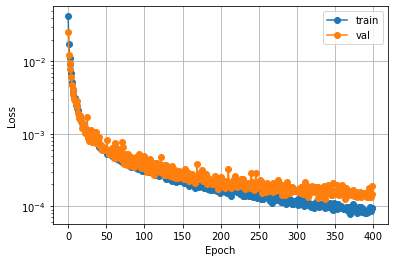

In [8]:
if 1 == 1:
    hist = train_regression(model, dataloaders, criterion, optimizer, num_epochs=400)
    plot_history(hist, log=True)
    model.save_checkpoint("models/L2_Net1_400_flip.pt")

Ah, great! It works!

# Inference

### Utilities

In [9]:
from sklearn.preprocessing import MinMaxScaler
import pickle
import pandas as pd
from sections import VERTEX_FUNCTIONS

l2_func, l2_params = VERTEX_FUNCTIONS['l2']

def imshow(tensor):
    """show first image in a tensor"""
    img = tensor[0].numpy() # shape(1,224,224) -> shape(224,224)
    img = img.squeeze()
    plt.imshow(img, cmap='gray');


In [10]:
model = Net1.from_checkpoint("models/L2_Net1_400_flip.pt")

# scaler
with open("dataset/L2_scaler.pkl", "rb") as fp:
    scaler = pickle.load(fp)

L2
Input size: 100, output size: 4
parameter names: h, tw, ba, ra


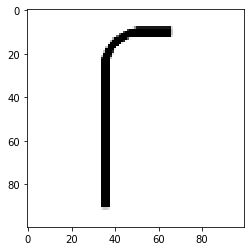

In [11]:
i = 67
area = 200

# get data point
ds = datasets['val']
image, target = ds[i]
# show image and target
imshow(image)

In [12]:
img = image.reshape(1, 1, 100, 100)
print(img.shape)
print(img.dtype)
print(img.max())
with torch.no_grad():
    model.eval()
    outputs = model.forward(img)
    outputs = outputs.numpy()
    
# print raw target / output
print(l2_params)

print("target (scaled): ", target.squeeze())
print("output (scaled): ", outputs.squeeze())

# unscale both, multiply with reference length (sqrt(A))
target_dim = np.sqrt(area) * scaler.inverse_transform(target.T)
target_dim = target_dim.squeeze()
output_dim = np.sqrt(area) * scaler.inverse_transform(outputs)
output_dim = output_dim.squeeze()
print("target (unscaled): ", target_dim)
print("output (unscaled): ", output_dim)

# generate vertices

torch.Size([1, 1, 100, 100])
torch.float32
tensor(1.)
['h', 'tw', 'ba', 'ra']
target (scaled):  [0.18140609 0.71524415 0.1976198  0.71125736]
output (scaled):  [0.18314792 0.7010044  0.20056257 0.7353648 ]
target (unscaled):  [62.82134859  2.51285394 24.50032595 10.67962926]
output (unscaled):  [62.984318   2.4829128 24.776804  10.972761 ]


In [13]:
# show results
df = pd.DataFrame([target_dim, output_dim], index=['true', 'predicted'], 
                  columns=l2_params)
df.round(2)

,h,tw,ba,ra
true,62.82,2.51,24.50,10.68
predicted,62.98,2.48,24.78,10.97


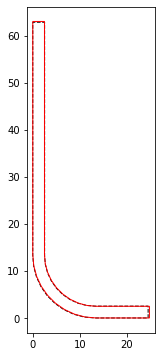

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))

# generate polygons
true_o, true_i = l2_func(*target_dim.squeeze())
pred_o, pred_i = l2_func(*output_dim.squeeze())


for outer in true_o:
    mppoly = plt.Polygon(outer, ec="k", ls='--', fill=False, linewidth=1)
    ax.add_patch(mppoly)
for inner in true_i:
    mppoly = plt.Polygon(inner, ec="k", ls='--', fill=False, linewidth=1)
    ax.add_patch(mppoly)
    
for outer in pred_o:
    mppoly = plt.Polygon(outer, ec="r", fill=False, linewidth=1)
    ax.add_patch(mppoly)
for inner in pred_i:
    mppoly = plt.Polygon(inner, ec="r", fill=False, linewidth=1)
    ax.add_patch(mppoly)

ax.autoscale(tight=False)
ax.set_aspect("equal")
#ax.axis("off");


### Evaluate: Compute IOU

In [ ]:
# to be completed

### Full Loop: Input polygon vertices, create image 

In [ ]:
# to be completed